# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# all relevant imports
import pickle
import csv
import random
import glob

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import os.path

# Visualizations will be shown in the notebook.
%matplotlib inline

In [2]:
# Load pickled data
# TODO: Fill this in based on where you saved the training and testing data
training_file = './traffic-signs-data/train.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.
# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_test.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

# get dict for signnames
with open('./signnames.csv', mode='r') as infile:
    header = infile.readline()
    data = csv.reader(infile)
    signnames = {int(rows[0]):rows[1] for rows in data}
    signnames[99]='Unknown Sign!'
    



Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

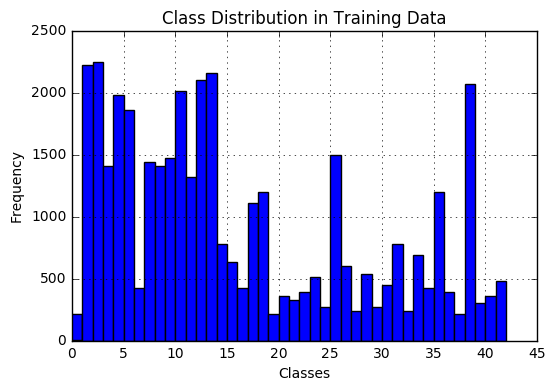

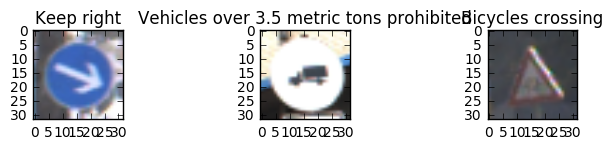

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
# figure 1: class distribution in training data
def plot_classes(data, n_classes, title='Class Distribution in Training Data'):
    plt.figure(1)
    plt.hist(data, bins=range(n_classes))
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid()
    plt.show()


# plot random example of image with signname as title
def plot_random_images(feats, labels, n_train):
    num_subplots = 3
    fig = plt.figure(2)
    for i in range(1, num_subplots+1):
        index = random.randint(0, n_train)
        fig.add_subplot(1, num_subplots, i)
        plt.imshow(feats[index])
        plt.title(signnames[labels[index]])
    plt.tight_layout()
    plt.show()

plot_classes(y_train, n_classes)
plot_random_images(X_train, y_train, n_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
def normalize_and_center(img):
    # convert from RGB to YUV
    img_YUV = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    # eualize histogram in Y channel
    img_YUV[:,:,0] = cv2.equalizeHist(img_YUV[:,:,0])
    # convert back to RGB
    image = cv2.cvtColor(img_YUV, cv2.COLOR_YUV2RGB)
    # normalize and center
    return (image/255.0)-0.5

def convert_data(dataset):
    ret = np.zeros((dataset.shape[0], 32, 32, 3))
    for i in range(dataset.shape[0]): 
        ret[i] = normalize_and_center(dataset[i])
    return ret


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**


Preprocessing:
- improved the contrast by equalizing the Y-channel (RGB -> YUV-Colorspace, cv2.equalizeHist on Y-channel, convert back to RGB). This operation should improve the contrast on low light images. Additionally, it improves the chosen normalization process, as the values are spread over the whole interval from 0 to 255. 
- normalized every image by dividing its channels by 255 and shifting it by 0.5, so every image is centered around 0 and has values within the interval [-0.5, 0.5]. This process will avoid huge gradients due to large input values and thus benefit training speed.
- no color conversion to grayscale or other colorspaces, because the first convolutional layer will be used to 'choose' the optimum colorspace (1x1x3-Filter)

Preprocessing is done after image augmentation (see below), as the affine transformations used are a lot faster with integer-values! 

In [6]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

#get additional data:
# rotate, shift, shear 

def shift_img(x_shift, y_shift):
    '''Calculate matrix to shift image by x_shift and y_shift pixels. Use matrix with cv2.warpAffine'''
    return np.float32([[1,0,x_shift],[0,1,y_shift]])

def rotate_img(img, deg):
    '''Calculate matrix to rotate image by deg degrees. Use matrix with cv2.warpAffine'''
    center = (img.shape[0]/2, img.shape[1]/2)
    return cv2.getRotationMatrix2D(center, deg, 1)

def shear_img(img, shear):
    '''Calculates a matrix to shear an image, based on a random variation of a given set of points, 
    with a maximum distance of 'shear from the original point, for every element of the new point. 
    Use matrix with cv2.warpAffine'''
    ori_pts = np.float32([[int(img.shape[0]*0.5) ,int(img.shape[1]*0.3) ],
                          [int(img.shape[0]*0.3) ,int(img.shape[1]*0.7) ],  
                          [int(img.shape[0]*0.7) ,int(img.shape[1]*0.3) ]])
    add = np.array(np.random.uniform(-1.0, 1.0, (3,2))*shear*1.0).astype(int)
    shear_matrix = cv2.getAffineTransform(ori_pts, np.add(ori_pts, add).astype('float32'))
    return shear_matrix  
    
def generate_images(img):
    '''Apply several affine transformations with random parameters as well as a contrast shift, to generate data'''
    # define parameters
    max_shear = 2
    max_rot = 20
    max_shift = 3
    # apply transformations   
    # get matrices for affine transformation
    m_shear = shear_img(img, np.random.uniform()*max_shear)
    m_rot = rotate_img(img, np.random.uniform(-1.0, 1.0)*max_rot)
    m_shift = shift_img(np.random.uniform(-1.0, 1.0)*max_shift, np.random.uniform(-1.0, 1.0)*max_shift)
    # combine matrices
    comb_matrix = combineTransformationMatrices(m_shear, m_rot, m_shift)
    #apply warpAffine
    out = cv2.warpAffine(img, comb_matrix, (32, 32))
    return out.reshape((1,32,32,3))

def combineTransformationMatrices(*args):
    '''Combine several transformation matrices to one'''
    matrices = [np.vstack([args[i], np.array([0, 0, 1])]) for i in range(len(args))]
    ret = args[0]
    for idx in range(1, len(args)):
        ret = np.matmul(ret, matrices[idx])
    
    return ret[:2, :3]
    
def augment_data(featureset, labelset, iterations, verbose=False):
    '''iterate over data and augment every image by 'iterations' images '''
    if verbose:
        print('Augmenting {0!s} images with {1!s} additional images...'.format(featureset.shape[0], iterations))
    img_indices = range(featureset.shape[0])
    for img_idx in img_indices:
        if verbose and img_idx % 500 ==0:
            print('Processing number: ', img_idx)
        for iters in range(iterations):
            featureset=np.vstack([featureset, generate_images(featureset[img_idx])])
            labelset=np.hstack([labelset, labelset[img_idx]])
    if verbose:
        print('.. Done!')
    return featureset, labelset



Testing Data Augmentation
Augmenting 2 images with 3 additional images...
Processing number:  0
.. Done!


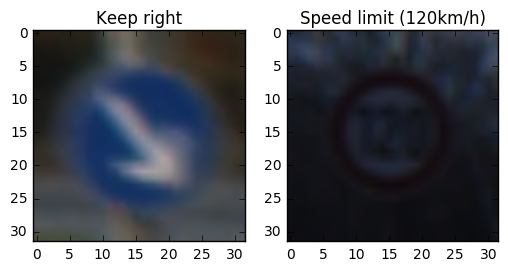

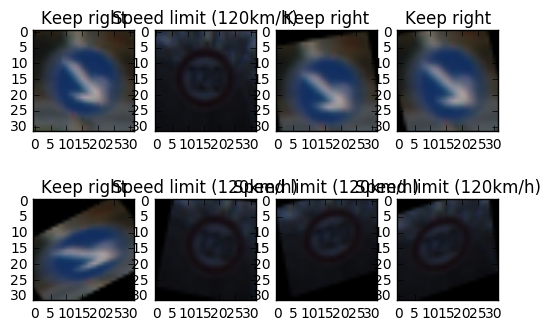

In [7]:
# test augment data
print('Testing Data Augmentation')
add_images = 3 # num of additional images to add for each image in dataset 
num_feats = 2 # num of testimages
X, y = shuffle(X_train, y_train) # shuffle for fun
# slice
feats = X[0:num_feats]
labels = y[0:num_feats]
# augment
X_aug, y_aug = augment_data(feats, labels, add_images, verbose=True)
#plot the original images
fig = plt.figure(1)
for i in range(num_feats):
    fig.add_subplot(1,num_feats, i+1)
    plt.imshow(feats[i].reshape((32,32,3)))
    plt.title(signnames[labels[i]])
# plot the augmented set
fig = plt.figure(2)    
for i in range((add_images+1)*num_feats):
    fig.add_subplot(num_feats, add_images+1, i+1)
    plt.imshow(X_aug[i].reshape((32,32,3)))
    plt.title(signnames[y_aug[i]])

In [8]:
#check for existing file of preprocessed data
training_file = './traffic-signs-data/AugmentedData.p'
if os.path.isfile(training_file): 
    print('Loading data from {!s}....'.format(training_file), end='')
    with open(training_file, mode='rb') as f:
        data = pickle.load(f)
    
    X_train, y_train = data['X_train'], data['y_train']
    X_validation, y_validation = data['X_validation'], data['y_validation']
    print('... Done!')
    
else:   # if no file is found, augment and store data
    print('No augmented data found! Augmenting dataset now. This may take a while...')
    # split X_train in training and validation sets
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    # augment training data
    X_train, y_train = augment_data(X_train, y_train, 5, verbose=True)
    # save data 
    data = {'X_train':X_train, 'y_train':y_train, 'X_validation':X_validation, 'y_validation':y_validation, 
            'X_test':X_test, 'y_test':y_test}
    # save as pickle
    with open(training_file, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('... Done!')


Loading data from ./traffic-signs-data/AugmentedData.p....... Done!


In [9]:
# Preprocess (equalize, normalize and center) all data
X_train = convert_data(X_train)
X_validation = convert_data(X_validation)
X_test = convert_data(X_test)

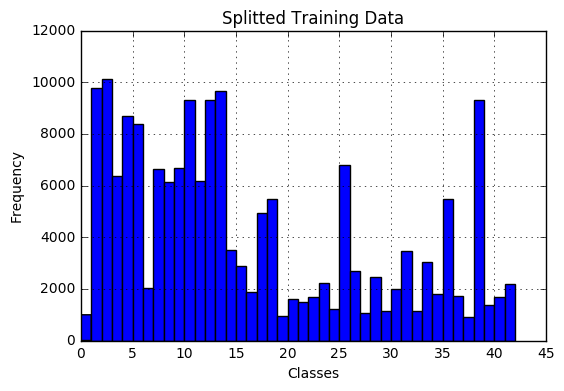

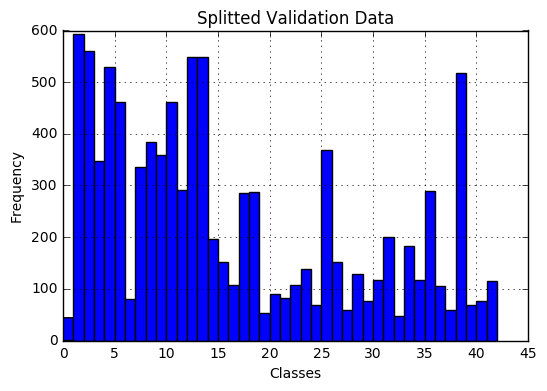

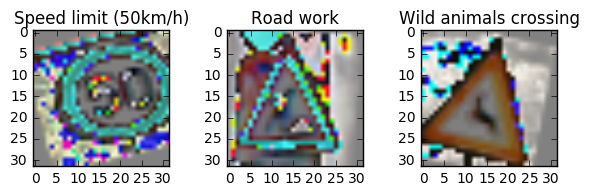

In [10]:
# plot classes of training and validation data
plot_classes(y_train, n_classes, 'Splitted Training Data')
plot_classes(y_validation, n_classes, 'Splitted Validation Data')

#plot_random_images of training data after preprocessing
plot_random_images(X_train, y_train, len(X_train))

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

#### Split Data:
I split the original training data in a training set (75%) and a validation set (25%) to monitor the training process, by using sklearns train-test-split with random sampling.

#### Data Augmentation:
For every image within the splitted training-set, 5 additional images were created. Maximum values (maxVal) for rotation, shift and shear of the image were used to generate uniform distributed random parameters from the interval [-maxVal, maxVal]. These parameters were used to calculate transformation matrices to warp the image (cv2. affineWarp). The max values were chosen carefully, as high rotation could alter the meaning of a sign (i.e. arrows on a sign), big shifts would possibly crop big parts of the sign. Large shear-values could result in both, cropping and altering the meaning of the sign.
Flipping was not used to not affect the meaning of the traffic signs. Additionally, altering the contrast was not improving the validation accuracy and thus not implemented.

This augmentation step was included to make classification accuracy invariant to the performed alterations (rotation, shift, shear), as well to minor cropping. This is one means to address overfitting. 

The augmented training set has the same class distribution, but is  6 times as large as the original dataset. It contains 5 additional images for each original image in the set as well as the original images. The additional images are affine transformations of the original, using rotation, shear and shift depending on a random parameters. 
Validation and test data were not augmented.

Class distribution was not balanced, as the distribution of the signs in real world traffic is not uniform. I could not find any references that describe the real distribution, so I expect the dataset was designed with this information in mind. Therefore, the bias induced by the distribution is tolerated or even wanted.  

The augmented data was saved for reuse, as the process is quite time consuming. It is applied before normalization, as the original data type is integer. The affine transformation is less computationaly demanding with integers than floats. 

#### Preprocessing:
After the augmentation step all data-sets were preprocessed (normalized, centered and equalized as described above). 

In [11]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

EPOCHS = 200
BATCH_SIZE = 256

# Helperfunctions
from tensorflow.contrib.layers import flatten

def conv2d(x, W, b, strides=1, padding='VALID', name=''):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x, name=name)

def maxpool2d(x, size=2, step=2,padding='VALID', name=''):
    return tf.nn.max_pool(x, ksize=[1, size, size, 1], strides=[1, step, step, 1], padding=padding, name=name)


In [12]:
# net architecture
def P2Net(x, keep_prob): 
    # Weight Initialization
    mu = 0
    sigma = 0.05
        
    layer_depth = {
    'layer_0': 3,
    'layer_1': 128,
    'down_2': 64,
    'layer_2': 64,
    'up_2': 128,
    'down_3': 64,
    'layer_3': 128,
    'up_3': 256,
    'down_4': 128,
    'layer_4': 128,
    'up_4': 256,
    'fully_connected_1': 1024,
    'fully_connected_2': 1024
    }
    
    # (height, width, input_depth, output_depth)
    weights = {
    'layer_0': tf.Variable(tf.truncated_normal(
        [1, 1, 3, layer_depth['layer_0']], mean = mu, stddev = sigma), name='w_l0'),
    'layer_1': tf.Variable(tf.truncated_normal(
        [3, 3, layer_depth['layer_0'], layer_depth['layer_1']], mean = mu, stddev = sigma), name='w_l1'),
    'down_2': tf.Variable(tf.truncated_normal(
        [1, 1, layer_depth['layer_1'], layer_depth['down_2']], mean = mu, stddev = sigma), name='w_d2'),
    'layer_2': tf.Variable(tf.truncated_normal(
        [3, 3, layer_depth['down_2'], layer_depth['layer_2']], mean = mu, stddev = sigma), name='w_l2'),
    'up_2': tf.Variable(tf.truncated_normal(
        [1, 1, layer_depth['layer_2'], layer_depth['up_2']], mean = mu, stddev = sigma), name='w_u2'),
    'down_3': tf.Variable(tf.truncated_normal(
        [1, 1, layer_depth['up_2'], layer_depth['down_3']], mean = mu, stddev = sigma), name='w_d3'),
    'layer_3': tf.Variable(tf.truncated_normal(
        [3, 3, layer_depth['down_3'], layer_depth['layer_3']], mean = mu, stddev = sigma), name='w_l3'),
    'up_3': tf.Variable(tf.truncated_normal(
        [1, 1, layer_depth['layer_3'], layer_depth['up_3']], mean = mu, stddev = sigma), name='w_u3'),
    'down_4': tf.Variable(tf.truncated_normal(
        [1, 1, layer_depth['up_3'], layer_depth['down_4']], mean = mu, stddev = sigma), name='w_d4'),
    'layer_4': tf.Variable(tf.truncated_normal(
        [3, 3, layer_depth['down_4'], layer_depth['layer_4']], mean = mu, stddev = sigma), name='w_l4'),
    'up_4': tf.Variable(tf.truncated_normal(
        [1, 1, layer_depth['layer_4'], layer_depth['up_4']], mean = mu, stddev = sigma), name='w_u4'),
    'fully_connected_1': tf.Variable(tf.truncated_normal(
        [6400, layer_depth['fully_connected_1']], mean = mu, stddev = sigma), name='w_fc1'),
    'fully_connected_2': tf.Variable(tf.truncated_normal(
        [layer_depth['fully_connected_1'], layer_depth['fully_connected_2']], 
                mean = mu, stddev = sigma), name='w_fc2'),
    'out': tf.Variable(tf.truncated_normal(
        [layer_depth['fully_connected_2'], n_classes], mean = mu, stddev = sigma), name='w_out')
         }
         
    biases = {
    'layer_0': tf.Variable(tf.zeros(layer_depth['layer_0']), name='b_l0'),  
    'layer_1': tf.Variable(tf.zeros(layer_depth['layer_1']), name='b_l1'),
    'down_2': tf.Variable(tf.zeros(layer_depth['down_2']), name='b_d2'),
    'layer_2': tf.Variable(tf.zeros(layer_depth['layer_2']), name='b_l2'),
    'up_2': tf.Variable(tf.zeros(layer_depth['up_2']), name='b_u2'),    
    'down_3': tf.Variable(tf.zeros(layer_depth['down_3']), name='b_d3'),
    'layer_3': tf.Variable(tf.zeros(layer_depth['layer_3']), name='b_l3'),
    'up_3': tf.Variable(tf.zeros(layer_depth['up_3']), name='b_u3'),    
    'down_4': tf.Variable(tf.zeros(layer_depth['down_4']), name='b_d4'),
    'layer_4': tf.Variable(tf.zeros(layer_depth['layer_4']), name='b_l4'),
    'up_4': tf.Variable(tf.zeros(layer_depth['up_4']), name='b_u4'),    
    'fully_connected_1': tf.Variable(tf.zeros(layer_depth['fully_connected_1']), name='b_fc1'),
    'fully_connected_2': tf.Variable(tf.zeros(layer_depth['fully_connected_2']), name='b_fc2'),
    'out': tf.Variable(tf.zeros(n_classes), name='b_out')
    }
    
    
    #Layer 0: Convolutional. Input = 32x32x3. Output = 32x32x3.
    conv0 = conv2d(x, weights['layer_0'], biases['layer_0'], name='conv0')
    
    #Layer 1: Convolutional.Input = 32x32x3 Output = 30x30x128. 
    conv1 = conv2d(conv0, weights['layer_1'], biases['layer_1'], name='conv1')  
    
    #Layer 2: Convolutional.Input = 30x30x128 Output = 28x28x128.
    #Using Bottleneck Structure: 1x1 conv -> 3x3 conv - 1x1 conv        
    #1x1 conv to increase depth
    down2 = conv2d(conv1, weights['down_2'], biases['down_2'], name='down2')
    # 3x3 conv
    conv2 = conv2d(down2, weights['layer_2'], biases['layer_2'], name='conv2')
    conv2_drop = tf.nn.dropout(conv2, keep_prob, name='conv2_drop')    
    #1x1 conv to increase depth
    up2 = conv2d(conv2_drop, weights['up_2'], biases['up_2'], name='up2')
    
    #Pooling. Input = 28x28x128. Output = 14x14x128.
    pool2 = maxpool2d(up2, size=2, step=2, name='pool2')
    
    #Layer 3: Convolutional.Input = 14x14x128 Output = 12x12x256.
    #Using Bottleneck Structure: 1x1 conv -> 3x3 conv - 1x1 conv
    #1x1 conv to increase depth
    down3 = conv2d(pool2, weights['down_3'], biases['down_3'], name='down3')
    # 3x3 conv
    conv3 = conv2d(down3, weights['layer_3'], biases['layer_3'], name='conv3')    
    #1x1 conv to increase depth
    up3 = conv2d(conv3, weights['up_3'], biases['up_3'], name='up3')
    
    #Layer 4: Convolutional.Input = 12x12x256 Output = 10x10x256.
    #Using Bottleneck Structure: 1x1 conv -> 3x3 conv - 1x1 conv
    #1x1 conv to increase depth
    down4 = conv2d(up3, weights['down_4'], biases['down_4'], name='down4')
    # 3x3 conv
    conv4 = conv2d(down4, weights['layer_4'], biases['layer_4'], name='conv4')
    conv4_drop = tf.nn.dropout(conv4, keep_prob, name='conv4_drop')    
    #1x1 conv to increase depth
    up4 = conv2d(conv4_drop, weights['up_4'], biases['up_4'], name='up4')
    
    #Pooling. Input = 10x10x256. Output = 5x5x256.
    pool4 = maxpool2d(up4, size=2, step=2, name='pool4')
      
    #Flatten.
    #Input 1 = 5x5x64. Output = 1600.
    #Input 2 = 14x14x16. Output = 3136.
    #Layer 3: Fully Connected. Input = 4736. Output = 1024.
    #Activation.
    fc1_1 = flatten(pool4)
    #fc1_2 = flatten(pool2)
    #fc1 = tf.concat(1, [fc1_1, fc1_2])
    fc1 = tf.nn.relu(tf.add( tf.matmul(fc1_1, weights['fully_connected_1']), biases['fully_connected_1']), 
                     name='fc1')
    fc1_drop = tf.nn.dropout(fc1, keep_prob, name='fc1_drop')

    #Layer 4: Fully Connected. Input = 512. Output = 256.
    #Activation.
    fc2 = tf.nn.relu(tf.add( tf.matmul(fc1_drop, weights['fully_connected_2']), biases['fully_connected_2']), 
                     name='fc2')
    fc2_drop = tf.nn.dropout(fc2, keep_prob, name='fc2_drop')
    #Layer 5: Fully Connected. Input = 256. Output = 43.
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'], name='logits')
    softmax_v = tf.nn.softmax(logits, name='labels')
    labels = tf.argmax(softmax_v, dimension=1)
    softmax_values=tf.nn.top_k(softmax_v, k=5)
    return logits, softmax_values, labels

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

!['Architecture'](./P2.jpg)




The network consists of 5 convolutional and 2 fully connected  sequentially arranged layers. The input are 32x32x3 RGB-images that are classified in 43 classes.

The first 1x1x3 convolution in 'Layer 0' is used to determine the 'best' colorspace conversion by training, not changing the image dimensions.
 
Imitating the LeNet-5 implementation, this net features two consecutive 3x3 convolutions (Layers 1 and 2, instead of one 5x5 conv, as presented in Stanfords CS 231n class) followed by MaxPooling. Layers 3 and 4 are also 3x3 convs followed by MaxPooling. 

Three of the convolutional layers (Layers 2, 3 and 4) are "Bottleneck-Sandwich"-Layers that actually consist of 3 seperate convolutional layers, two 1x1 convolutions at the beginning and end, as well as a 3x3 convolution in the middle.

Two fully connected layers follow after the convolutional layers, each containing 1024 nodes. 

Each convolution and each fc-layer is activated by ReLU-functions.

Dropout was applied in Layer 2 and 4 after the 3x3 convolutions as well as after every fc-layer.

In [13]:
### Train your model here.
### Feel free to use as many code cells as needed.
x = tf.placeholder(tf.float32, (None, 32, 32, 3), name='x')
y = tf.placeholder(tf.int32, (None), name='y')
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
#Training Pipeline
rate = 0.0001
global_step= tf.Variable(0)
learning_rate = tf.train.exponential_decay(rate, global_step, 1000, 0.95, staircase=True)

logits, softmax_values, labels = P2Net(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation, global_step=global_step)
init = tf.global_variables_initializer()

#Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    loss = []
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        _, accuracy, batch_loss = sess.run([training_operation, accuracy_operation, loss_operation], 
                                           feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        loss.append(batch_loss)
    return total_accuracy / num_examples, np.mean(loss)

In [14]:
training_loss = []
train_accuracy = []
valid_accuracy = []
valid_loss=[]
min_loss = 3.5
# Train Model
with tf.Session() as sess:
    sess.run(init)
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        training_accuracy = 0
        batch_loss = []
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, accuracy, loss = sess.run([training_operation, accuracy_operation, loss_operation], 
                                         feed_dict={x: batch_x, y: batch_y, keep_prob: 0.75})
            batch_loss.append(loss)
            training_accuracy += (accuracy * len(batch_x))      
        training_loss.append(np.mean(batch_loss))
        train_accuracy.append(training_accuracy/len(X_train))
        val_acc, val_loss = evaluate(X_validation, y_validation)
        valid_accuracy.append(val_acc)
        valid_loss.append(val_loss)
        if i%5==0:
            print("EPOCH {} ...".format(i+1))
            print("Training Accuracy = {:.3f},  Training Loss = {:.5f}".format(train_accuracy[-1], training_loss[-1]))
            print("Validation Accuracy = {:.3f},  Validation Loss = {:.5f}".format(valid_accuracy[-1], valid_loss[-1]))
            print()
        #update min_loss
        if i>10 and valid_loss[-1]<min_loss: 
            min_loss = valid_loss[-1]
            try:
                saver
            except NameError:
                saver = tf.train.Saver()
            saver.save(sess, './P2Net.ckpt')
            print("EPOCH {} ... Model saved!".format(i+1))
            print("Training Accuracy = {:.3f},  Training Loss = {:.5f}".format(train_accuracy[-1], training_loss[-1]))
            print("Validation Accuracy = {:.3f},  Validation Loss = {:.5f}".format(valid_accuracy[-1], valid_loss[-1]))
            print()
        elif i>15 and ((min_loss not in valid_loss[-5:]) or (np.isclose([valid_accuracy[-1]], [1.00], rtol=1e-02)[0])):
            print('Early Stop!')

            break
            

Training...

EPOCH 1 ...
Training Accuracy = 0.094,  Training Loss = 3.33866
Validation Accuracy = 0.527,  Validation Loss = 1.51323

EPOCH 6 ...
Training Accuracy = 0.899,  Training Loss = 0.31243
Validation Accuracy = 0.982,  Validation Loss = 0.06242

EPOCH 11 ...
Training Accuracy = 0.954,  Training Loss = 0.13863
Validation Accuracy = 0.995,  Validation Loss = 0.01728

EPOCH 12 ... Model saved!
Training Accuracy = 0.959,  Training Loss = 0.12332
Validation Accuracy = 0.996,  Validation Loss = 0.01510

EPOCH 13 ... Model saved!
Training Accuracy = 0.963,  Training Loss = 0.11019
Validation Accuracy = 0.996,  Validation Loss = 0.01293

EPOCH 14 ... Model saved!
Training Accuracy = 0.967,  Training Loss = 0.09882
Validation Accuracy = 0.997,  Validation Loss = 0.01139

EPOCH 15 ... Model saved!
Training Accuracy = 0.971,  Training Loss = 0.08672
Validation Accuracy = 0.997,  Validation Loss = 0.00922

EPOCH 16 ...
Training Accuracy = 0.973,  Training Loss = 0.07859
Validation Accurac

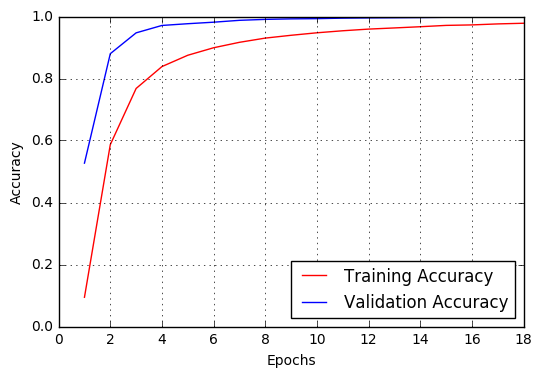

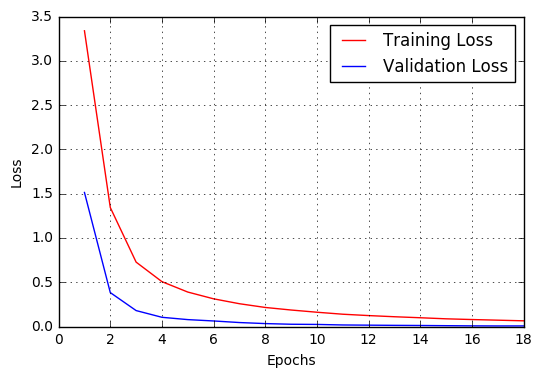

In [15]:
# plot Accuracy
plt.figure()
x_vals=range(1, len(train_accuracy)+1)
plt.plot(x_vals, train_accuracy, '-r', label='Training Accuracy')
plt.plot(x_vals, valid_accuracy, '-b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()
# plot loss
plt.figure()
plt.plot(x_vals, training_loss, '-r', label='Training Loss')
plt.plot(x_vals, valid_loss, '-b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid()
plt.show()

In [16]:
# get accuracy of test data
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('P2Net.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    # test data
    X_test, y_test = shuffle(X_test, y_test)
    
    accuracy, _ = evaluate(X_test, y_test)
    print("Test Accuracy: {:.3f}".format(accuracy))

Test Accuracy: 0.976


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
The sigma of the weights initialization was chosen by trial and error. Following values provided a good learning performance without a plateau at the start.
mu = 0, sigma = 0.05

Training took 56 Epochs until the early-stop condition was satisfied (no improvement in validation loss over 5 epochs)

For Batch Size, 256 samples were chosen to reduce the noise in the training loss and get good accuracy. Smaller/larger batch sizes were not showing improvements. 

The AdamOptimizer was used as it provided good performance. The initial learning rate (lr = 0.0001) is decaying with decay_steps = 1000 and decay_rate = 0.95 for finetuning in higher epochs. The loss plots show that the learning rate is reasonably chosen.


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

At the start, I read the LeNet paper to get a hint how such problems are usually addressed and started with the LeNet-5 implementation from the classroom which proved to be a good starting point. The MNIST data seems quite similar to the traffic sign data, except for the colorspace and the number of classes. Additionally, the traffic signs seem to be more complex than handwritten letters regarding the higher level structures that define each class as well as the lighting conditions and point of view (angle of the photographer towards the sign). Consequently, the general plan was to adapt LeNet-5 and change its features based on performance and common sense. 

First, I added dropout to address overfitting and changed input-colorspace to 3 channels, to take advantage of the additional color information. All input images were equalized (histogramm equalization on Y channel in YUV colorspace) to spread the intensity values over the whole interval [0, 255]. The rgb-values were normalized to [-.5, .5] and centered, to reduce the gradients and improve learning speed and accuracy. 

To address the question which colorspace to use, I implemented the 1x1x3 layer to 'choose' the preferred colorspace by training (there is a paper on this topic, but I can't find it anymore).
To further address potential overfitting and to make the model invariant to shear, rotation, shifting and small cropped areas, i added the data augmentation steps.   

To further takle overfitting, I reduced the models parameters by replacing the 5x5 convolutions with two successive 3x3 convolutions, as two consecutive 3x3 convs cover the same image area as one 5x5 convolution. To further reduce parameters and add more nonlinear functions, I implemented the "Bottleneck Sandwich"-Layers (as proposed in Stanfords CS231n class). I kept the original pooling layers (after two 3x3 convs -> maxpool).

Choosing filter depth and number of layers were trial and error, additional layers and higher filter depths were not improving the accuracy, although I have to admit that the number of experiments was limited.



---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

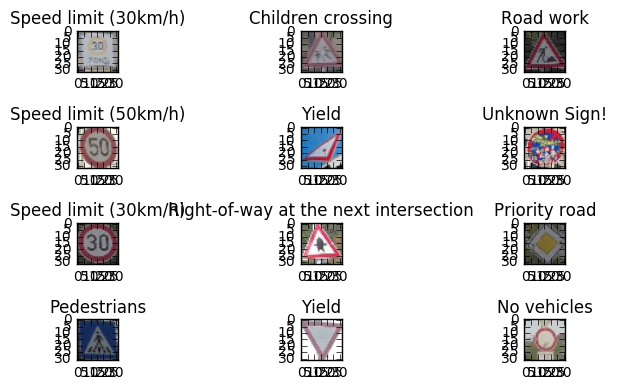

In [17]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
files = sorted(glob.glob('./ownImages/*.jpg'))
ownImages = np.ndarray(shape=(len(files), 32, 32, 3), dtype=np.uint8)
for idx, file in enumerate(files):
    ownImages[idx] = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
ownLabels = np.array([1, 28, 25, 2, 13, 99, 1, 11, 12, 27, 13, 15], dtype=np.int32)

# Plot images
fig=plt.figure(1)
for i in range(len(ownImages)):
    fig.add_subplot(len(ownImages)/3, 3, i+1)
    plt.imshow(ownImages[i])
    plt.title(signnames[ownLabels[i]])
plt.tight_layout()
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

1.: squared "Speed Limit 30 km/h": It is actually a "Zone 30"-Sign, not a common, round speed limit sign

2.: "Children Crossing": blurred with white spot in the middle

3.: "Road Work": no difficulties

4.: "Speed Limit (50km/h)": slight shear, no other dificulties

5.: "Yield": Taken from extreme angle, hard to recognize

6.: "Unknown Sign!": a "No Parking Allowed"-sign heavily altered with stickers. has the shape and red border of a speed limit and blue filling. The trining data didn't contain this class. Added it just for fun

7.: "Speed Limit (30 km/h)": no difficulties

8.: "Right of way at next intersection": no dificulties

9.: "Priority Road": no difficulties

10.: "Pedestrians": Actually a "Crosswalk" sign in germany, looks slightly similar to the pedestrians sign (no crosswalk, blue color)

11.: "Yield": no difficulties

12.:"No Vehicles": half of the "Priority Road"-Sign is in the Image, there is a sticker on the sign

In [18]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
# preprocess images
ownImg = convert_data(ownImages)

In [19]:
with tf.Session() as sess:
   
    loader = tf.train.import_meta_graph('P2Net.meta')
    #sess.run(tf.global_variables_initializer())
    loader.restore(sess, tf.train.latest_checkpoint('./'))
      
    labs, softmax = sess.run([labels, softmax_values], feed_dict={x: ownImg, y: ownLabels, keep_prob: 1})

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

On the given test set, the classifier scored 97,9%

On all(!) the images taken by myself, it scored 66,7%.

Without the signs not represented in the training set(no. 1, 6 and 10), the accuracy is 91,7%. Using more signs the net was trained on would probably lead to a similar accuracy as test-accuracy, as the only sign that was not classified correctly was the yield-sign taken from an extreme angle. This could also be addressed with larger shear values during data augmentation.

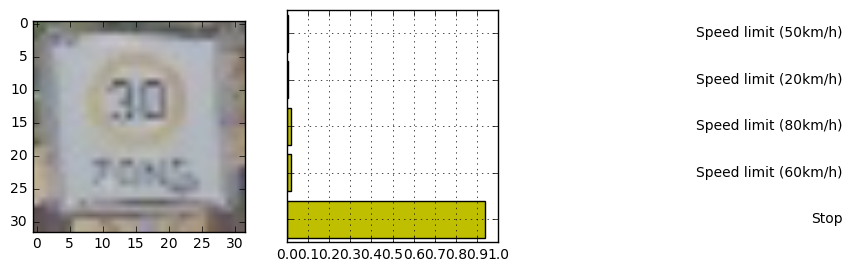

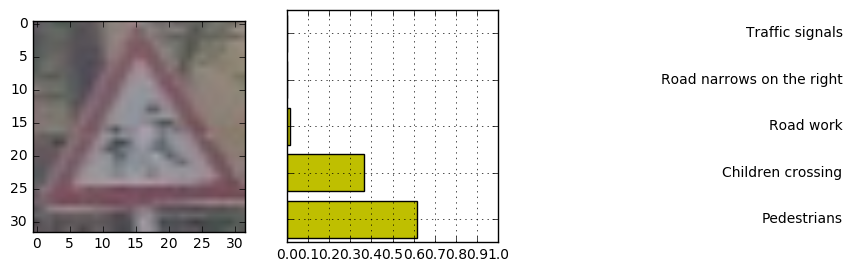

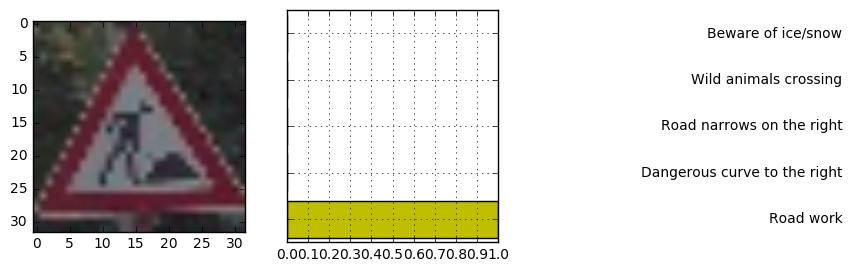

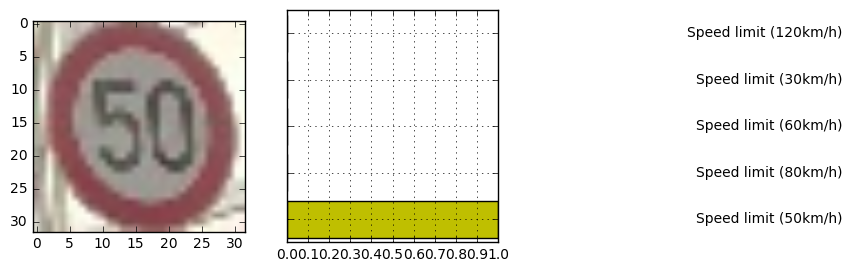

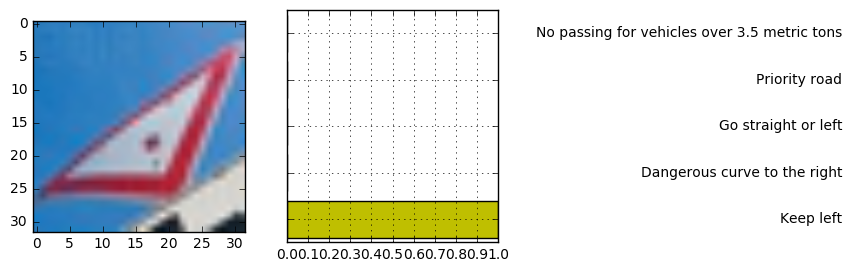

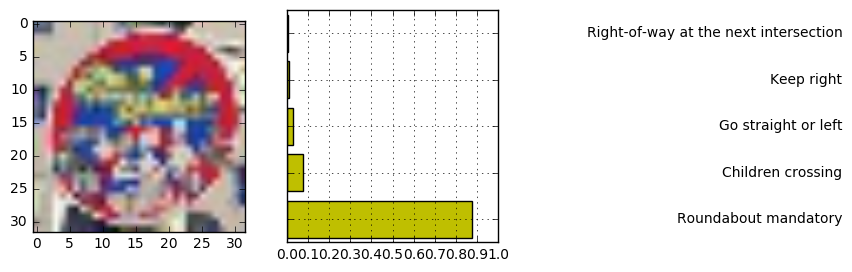

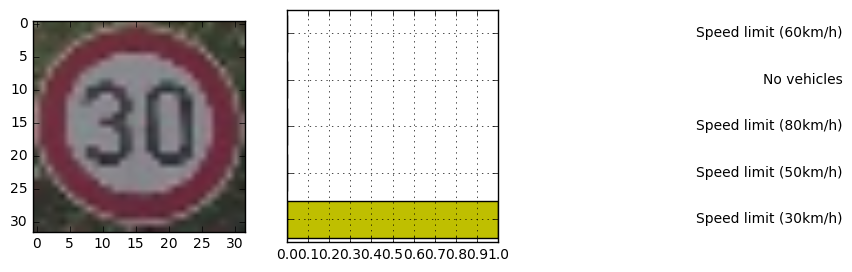

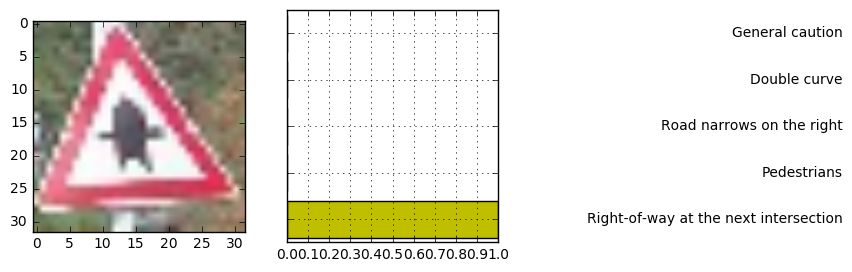

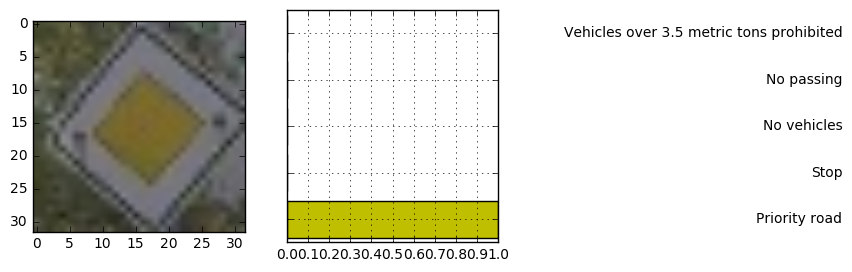

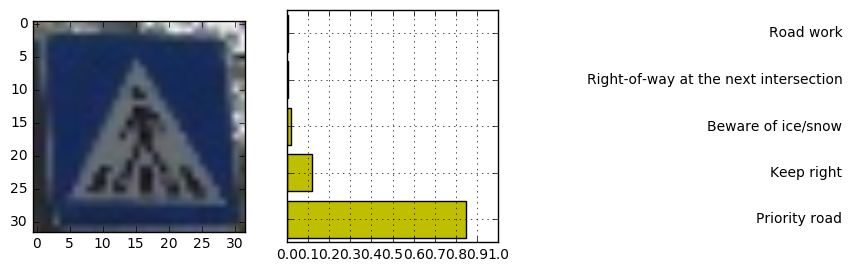

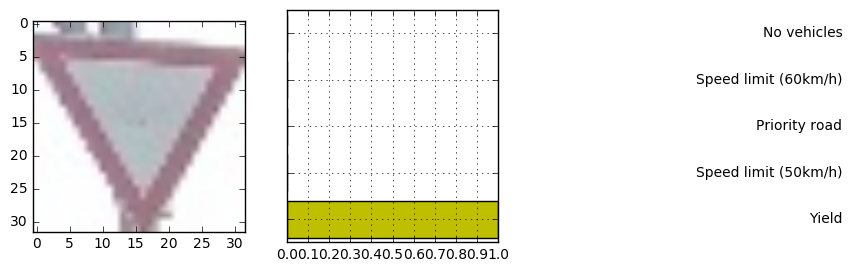

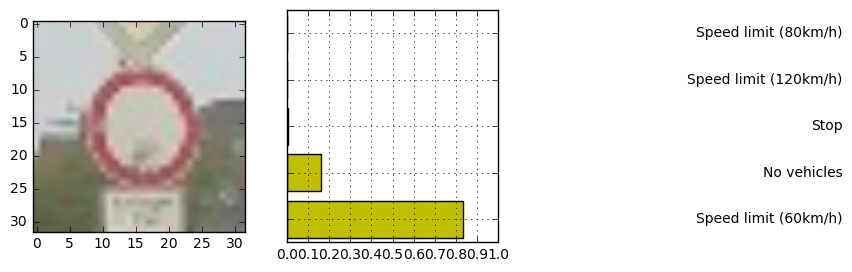

In [20]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
# plot hist
num_images= len(ownImages)
for idx in range(0, num_images):
    
    fig=plt.figure(idx, figsize=(6,3))
    #plot image
    ax1=fig.add_subplot(1, 2, 1)
    ax1.imshow(ownImages[idx])
    

    #plot softmax
    ax2=fig.add_subplot(1, 2, 2)
    labels=[signnames[i] for i in softmax.indices[idx]]
    ax2.barh(range(1,6), softmax.values[idx], color='y', align='center', tick_label=labels)
    ax2 = plt.gca()
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0.5, 5.5])
    ax2.get_yaxis().set_tick_params(direction='in', pad=-400)
    ax2.get_xaxis().set_ticks(np.arange(0,1.1,0.1))
    ax2.grid()

        
    #plt.tight_layout()
    plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*



**Answer:**

The net was trained until the validation loss didn't improve for 5 epochs, even though the validation accuracy was already 100%. This lead to a classifier which is really certain  about its predictions, the above plots prove this.

For all correct predictions, the probabilities of the correct class are almost 100%.

For all wrong predictions (images 1, 5, 6, 10) the classifier was also very certain, with the lowest accuracy being 85% in the first image.

Looking at the probabilities of wrong classifications shows interesting results:

- 1.Image: 
Class: 'Zone 30' - not in training data
Top 3 Predictions: 'Speed Limit 100km/h' - 85%, 'Speed Limit 60 km/h' - 7%, 'Keep Right' - 4%

The square 'Zone 30' sign actually looks like a 'Speed Limit 30km/h' sign, only with 'Zone 30' printed below. The classifier is quite sure that the sign is a Speed Limit, although the correct sign is not in the top 5 list. It is quite interesting that the 'Keep Right'-sign is in the top 3, although it has a different shape and is of a different color than the 'Zone 30' sign.

- 5.Image: 
Class: 'Yield' - extreme angle
Top 3 Predictions: 'Keep Left' ~ 100% , 'Go Straight or Left' ~0% , 'Turn right ahead' ~0%

The classifier is very certain about this prediction. Once more, the sign is of diferent shape and color than the predicted sign.

- 6.image: 
Class: 'Parking Prohibited' - not in training data, lots of stickers
Top 3 Predictions: 'Priority road' ~ 97% , 'Speed Limit 30 km/h' ~3% , 'Right of way at the next intersection' ~0%

Again, the classifier is very certain about this prediction although the sign is of diferent shape and color than the predicted sign. The second choice, with a probability of 3%, would be a more obvious choice due to the red border and the round shape.

- 10.image: 
Class: 'Crosswalk' - not in training data, similar to 'Pedestrians'
Top 3 Predictions: 'Right of way at the next intersection' ~ 95% , 'Road Work' ~3% , 'General Caution' ~2%

Although the 'Pedestrians' sign looks a lot like this sign, it is not even in the top 5. The main diference is the mising crosswalk and the different color. The triangular shape and the walking person look the same. On a second glance, the similarities to the predicted sign become obvious: color scheme, triangular shape of the red border, black blob in the middle with 'arms'...

Seeing those missclassifications, it gets obvious that the descision making process is quite abstract and can't be boiled down to just imagecolors and a few shapes. The softmax probabilities on signs that are apparently similar to some classes of the training data are astounding.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.